### Import modules and constants

In [1]:
import json
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

packets_to_clone=200
countmin_aging_threshold=10
countmin_width=16384

### Define the functions that can read the alerts and number of packets redirected from the results

In [2]:
def read_snort_alerts(alert_filepath):
	no_duplicates_data = {}
	data = []
	with open(alert_filepath) as file:
		try:
			for line in file.readlines():
				parsed_line = json.loads(line)
				data.append(parsed_line)

				entry_key = str(parsed_line["pkt_num"]) + parsed_line["rule"] + parsed_line["timestamp"]
				if entry_key not in no_duplicates_data:
					no_duplicates_data[entry_key] = line	
		except Exception as e:
			print("JSON error: ", e)
	return data,  no_duplicates_data

def read_rules_offloaded_and_pkts_cloned(experiment_output_filepath):
	try:
		with open(experiment_output_filepath) as file:
			rules_offloaded_by_sw = {}
			packets_cloned = 0
			get_data = False
			previous_line = ""
			for line in file:
				if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
					get_data = True

				if "packet_count" in line and get_data==True:
					packets_cloned += int(line.split()[1])
					get_data = False

				if "Usage for NIDS table entries:" in line:
					splitted_line = line.split()
					rules_offloaded_by_sw[splitted_line[0]] = int(splitted_line[-1])

				previous_line = line
	except Exception as e:
		print("Exception: ", e.args)
	return rules_offloaded_by_sw, packets_cloned

### Read the results of one complete experiment: Monday, Tuesday, etc.

In [3]:
def read_experiments_data(experiments_data_folder):
	folder_data = {}
	for item in os.listdir(experiments_data_folder):
		item_fullpath = os.path.join(experiments_data_folder, item)
		if os.path.isfile(item_fullpath):
			continue

		no_duplicates_data, final_data = {}, {}		
		for subdir in sorted(os.listdir(item_fullpath)):
			if os.path.isfile(os.path.join(item_fullpath, subdir)):
				continue

			alert_file = os.path.join(item_fullpath, subdir) + "/alert_json.txt"
			data, no_duplicates =  read_snort_alerts(alert_file)
			this_subdir_rules = set()
			for key, value in no_duplicates.items():
				packet = json.loads(value)
				new_key = packet["proto"]+str(packet["pkt_len"])+packet["dir"]+packet["src_ap"]+packet["dst_ap"]+packet["rule"]
				if new_key not in no_duplicates_data:
					no_duplicates_data[new_key] = value
					final_data[value] = value
					this_subdir_rules.add(new_key)
					
				if new_key in no_duplicates_data and new_key in this_subdir_rules:
					final_data[value] = value
		rules_offloaded_by_sw, packets_cloned = read_rules_offloaded_and_pkts_cloned(os.path.join(item_fullpath, "stdout_output.txt"))
		folder_data[item]={"alerts": final_data, "packets_cloned": packets_cloned, "rules_offloaded_by_sw": rules_offloaded_by_sw}
	return folder_data

### Parse the parameters evaluation experiments

In [4]:
input_folder = "/home/ubuntu/p4-ddos/brum-p4/results/algorithms"
csv_data = []
for item in os.listdir(input_folder):
    item_fullpath = os.path.join(input_folder, item)
    if os.path.isfile(item_fullpath):
        continue

    folder_name_elements = item.split("_") # linear_simple_100_registered
    experiments_data = read_experiments_data(item_fullpath)
     
    for key, data in experiments_data.items():
        csv_line = {}
        
        csv_line["pcap"] = key
        csv_line["topology"] = folder_name_elements[0]
        csv_line["algorithm"] = folder_name_elements[1]
        csv_line["space"] = folder_name_elements[2]
        csv_line["alerts"] = len(data["alerts"])
        csv_line["packets_cloned_NIDS"] = data["packets_cloned"]
        csv_line["table_entries"] = sum(data["rules_offloaded_by_sw"].values())
        csv_data.append(csv_line)

original_df = pd.DataFrame(csv_data, columns=csv_data[0].keys())
pd.set_option('display.max_rows', None)  

display(original_df)

,pcap,topology,algorithm,space,alerts,packets_cloned_NIDS,table_entries
0,Friday,linear,firstfit,25,82736,4784984,1079
1,Thursday,linear,firstfit,25,80473,4794113,1079
2,Wednesday,linear,firstfit,25,84121,6650824,1079
3,Tuesday,linear,firstfit,25,65940,6028455,1079
4,Monday,linear,firstfit,25,75119,5987397,1079
5,Friday,linear,bestfit,100,83060,5308373,1465
6,Thursday,linear,bestfit,100,80538,4691467,1465
7,Wednesday,linear,bestfit,100,279886,7550792,1465
8,Tuesday,linear,bestfit,100,65481,5918643,1465
9,Monday,linear,bestfit,100,74808,5818073,1465


### Adjust dataframes for each topology and algorithms and calculate the alerts and packets cloned compared to the baseline

In [5]:
pd.set_option('display.max_rows', 30)  

complete_df = original_df.copy()
complete_df["space"] = complete_df["space"].astype("int")
complete_df = complete_df.sort_values("space", ascending=False)
display(complete_df)
alerts_comp_baseline = []
packets_cloned_comp_baseline = []

linear_baseline = complete_df[(complete_df["topology"]=="linear") & (complete_df["algorithm"] == "simple") & (complete_df["space"]==100)]
linear_baseline_dict = linear_baseline.set_index("pcap").to_dict('index')
linear_df = complete_df[(complete_df["topology"]=="linear")]

for index, row in linear_df.iterrows():
    alerts_comp_baseline.append(row["alerts"]/linear_baseline_dict[row["pcap"]]["alerts"]*100)
    packets_cloned_comp_baseline.append(row["packets_cloned_NIDS"]/linear_baseline_dict[row["pcap"]]["packets_cloned_NIDS"]*100)

linear_df = linear_df.assign(alerts_compared_baseline=alerts_comp_baseline)
linear_df = linear_df.assign(packets_cloned_compared_baseline=packets_cloned_comp_baseline)

alerts_comp_baseline = []
packets_cloned_comp_baseline = []

# tree_baseline = complete_df[(complete_df["topology"]=="tree") & (complete_df["algorithm"] == "simple") & (complete_df["space"]==100)]
# tree_baseline_dict = linear_baseline.set_index("pcap").to_dict('index')
# tree_df = complete_df[(complete_df["topology"]=="linear")]

# for index, row in tree_df.iterrows():
#     alerts_comp_baseline.append(row["alerts"]/tree_baseline_dict[row["pcap"]]["alerts"]*100)
#     packets_cloned_comp_baseline.append(row["packets_cloned_NIDS"]/tree_baseline_dict[row["pcap"]]["packets_cloned_NIDS"]*100)

# tree_df = tree_df.assign(alerts_compared_baseline=alerts_comp_baseline)
# tree_df = tree_df.assign(packets_cloned_compared_baseline=packets_cloned_comp_baseline)

linear_simple = linear_df[(linear_df["algorithm"] == "simple")].drop(["topology", "algorithm"], axis=1)
# tree_simple = tree_df[(tree_df["algorithm"] == "simple")].drop(["topology", "algorithm"], axis=1)

linear_firstfit = linear_df[(linear_df["algorithm"] == "firstfit")].drop(["topology", "algorithm"], axis=1)
# tree_firstfit = tree_df[(linear_df["algorithm"] == "firstfit")].drop(["topology", "algorithm"], axis=1)

linear_bestfit = linear_df[(linear_df["algorithm"] == "bestfit")].drop(["topology", "algorithm"], axis=1)
# tree_bestfit = tree_df[(linear_df["algorithm"] == "bestfit")].drop(["topology", "algorithm"], axis=1)



,pcap,topology,algorithm,space,alerts,packets_cloned_NIDS,table_entries
59,Monday,linear,firstfit,100,74552,5818062,1465
8,Tuesday,linear,bestfit,100,65481,5918643,1465
44,Monday,linear,simple,100,75083,5818073,1464
41,Thursday,linear,simple,100,80594,4691467,1464
40,Friday,linear,simple,100,83130,5308373,1464
...,...,...,...,...,...,...,...
22,Wednesday,linear,simple,25,75430,396847,366
23,Tuesday,linear,simple,25,57726,394004,366
24,Monday,linear,simple,25,68206,499952,366
1,Thursday,linear,firstfit,25,80473,4794113,1079


In [6]:
display(linear_bestfit[(linear_bestfit["pcap"] == "Friday")])
display(linear_simple[(linear_simple["pcap"] == "Friday")])


,pcap,space,alerts,packets_cloned_NIDS,table_entries,alerts_compared_baseline,packets_cloned_compared_baseline
5,Friday,100,83060,5308373,1465,99.915795,100.000000
45,Friday,75,83239,5308373,1465,100.131120,100.000000
10,Friday,50,83114,5643448,1465,99.980753,106.312198
15,Friday,25,81731,4773957,1156,98.317094,89.932584


,pcap,space,alerts,packets_cloned_NIDS,table_entries,alerts_compared_baseline,packets_cloned_compared_baseline
40,Friday,100,83130,5308373,1464,100.000000,100.000000
25,Friday,75,82335,1305348,1098,99.043667,24.590359
30,Friday,50,80812,660217,732,97.211596,12.437276
20,Friday,25,80181,378940,366,96.452544,7.138534


### Create the sub dataframes for each offloading algorithm and topology

In [7]:
def create_sub_dataframes(df):    
    alerts_df = df[["pcap", "space", "alerts_compared_baseline"]].pivot_table("alerts_compared_baseline", ["space"], "pcap")
    packets_df = df[["pcap", "space", "packets_cloned_compared_baseline"]].pivot_table("packets_cloned_compared_baseline", ["space"], "pcap")

    alerts_df.index = alerts_df.index.map(str)
    packets_df.index = packets_df.index.map(str)

    alerts_df = alerts_df[::-1]
    packets_df = packets_df[::-1]
    
    return alerts_df, packets_df

In [8]:
alerts_linear_simple_df, packets_linear_simple_df = create_sub_dataframes(linear_simple)
# alerts_tree_simple_df, packets_tree_simple_df = create_sub_dataframes(tree_simple)

alerts_linear_firstfit_df, packets_linear_firstfit_df = create_sub_dataframes(linear_firstfit)
# alerts_tree_firstfit_df, packets_tree_firstfit_df = create_sub_dataframes(tree_firstfit)

alerts_linear_bestfit_df, packets_linear_bestfit_df = create_sub_dataframes(linear_bestfit)
# alerts_tree_bestfit_df, packets_tree_bestfit_df = create_sub_dataframes(tree_bestfit)

### "Alerts" and "packets cloned" plotting functions 

In [9]:
def plot_alerts(df, filename, anchored_legend=True):
    df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,3,4,2,0]
    if anchored_legend:
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=[0.5, 0.38], loc='center', borderaxespad=0)
    else:
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    
    plt.ylabel("% of alerts relative to the baseline")
    plt.tight_layout()
    plt.savefig(filename)

def plot_packets_cloned(df, filename):
    df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,3,4,2,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.ylabel("% of packets cloned to the NIDS\n relative to the baseline")
    plt.tight_layout()
    plt.savefig(filename)


### Plot random graphs

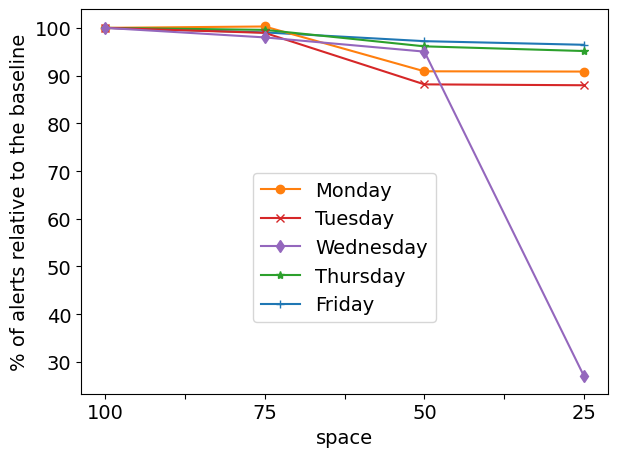

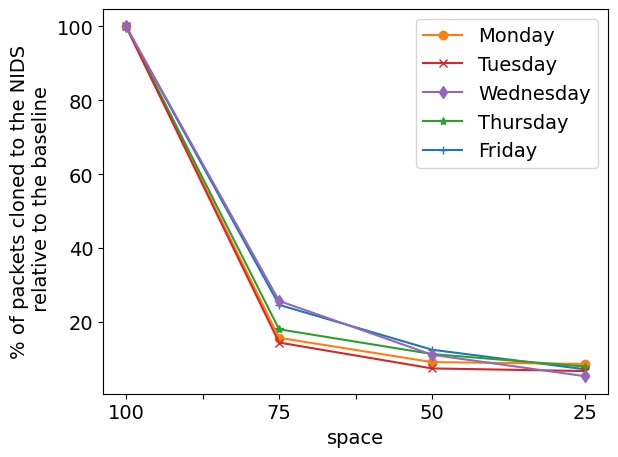

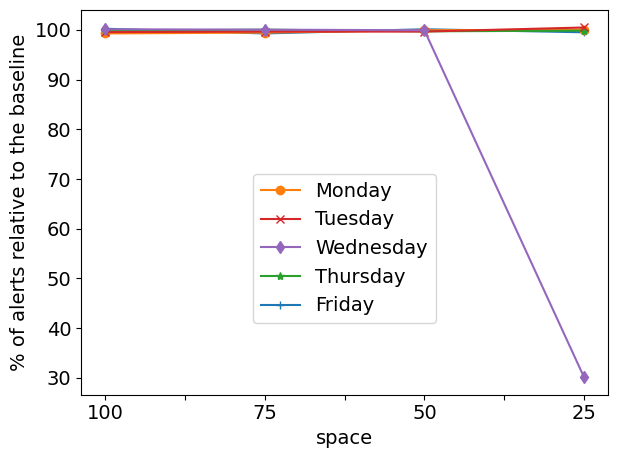

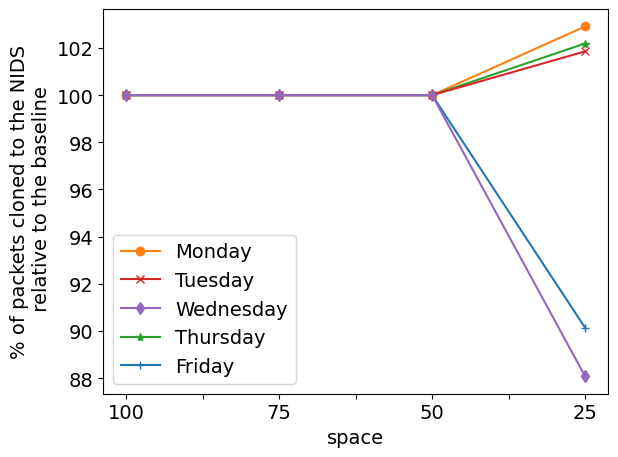

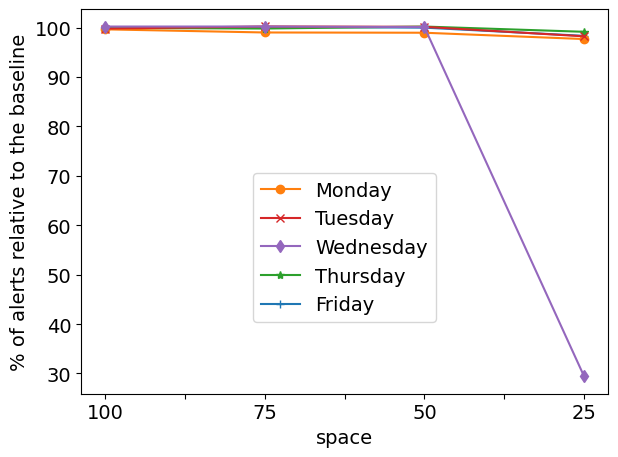

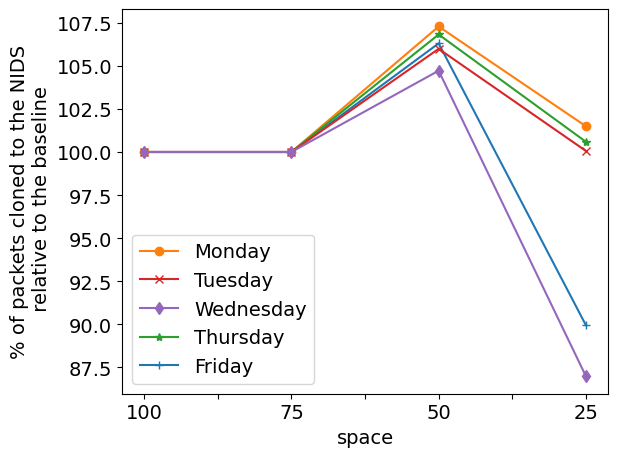

In [10]:
plt.rcParams.update({'font.size': 14})

plot_alerts(alerts_linear_simple_df, "algorithms_graphs/Alerts_linear_simple.png")
plot_packets_cloned(packets_linear_simple_df, "algorithms_graphs/Packets_cloned_linear_simple.png")

# plot_alerts(alerts_tree_simple_df, "algorithms_graphs/Alerts_tree_simple.png", False)
# plot_packets_cloned(packets_tree_simple_df, "algorithms_graphs/Packets_cloned_simple.png")

plot_alerts(alerts_linear_firstfit_df, "algorithms_graphs/Alerts_linear_firstfit.png")
plot_packets_cloned(packets_linear_firstfit_df, "algorithms_graphs/Packets_cloned_linear_firstfit.png")

# plot_alerts(alerts_tree_firstfit_df, "algorithms_graphs/Alerts_tree_firstfit.png")
# plot_packets_cloned(packets_tree_firstfit_df, "algorithms_graphs/Packets_cloned_tree_firstfit.png")

plot_alerts(alerts_linear_bestfit_df, "algorithms_graphs/Alerts_linear_bestfit.png")
plot_packets_cloned(packets_linear_bestfit_df, "algorithms_graphs/Packets_cloned_linear_bestfit.png")

# plot_alerts(alerts_tree_bestfit_df, "algorithms_graphs/Alerts_tree_bestfit.png")
# plot_packets_cloned(packets_tree_bestfit_df, "algorithms_graphs/Packets_cloned_tree_bestfit.png")

### Plot the memory utilization 

In [11]:
def create_memory_usage_dataframe(df, topology):
    reduced_df = df[(df["Topology"]==topology) | (df["Offloading algorithm"]=="simple") & ~(df["Offloading algorithm"].str.contains("random"))]
    reduced_df = reduced_df[["Offloading algorithm", "Available space (%)", "Table entries used"]]
    reduced_df = reduced_df.drop_duplicates(subset=["Offloading algorithm", "Available space (%)"], keep='last')
    reduced_df = reduced_df.reset_index(drop=True) 
    reduced_df = reduced_df.pivot_table("Table entries used", ["Available space (%)"], "Offloading algorithm")
    reduced_df = pd.DataFrame(reduced_df, columns=['simple','firstfit','bestfit'])

    return reduced_df

def plot_memory_usage(df, duplicate_memory, filename):
    _, ax = plt.subplots()
    df.plot(kind='bar', ax=ax, width=0.7) 
    duplicate_memory.plot(kind='bar', ax=ax, rot=0, width=0.7, color=['grey'], edgecolor='black')


    grey_patch = mpatches.Patch(color='grey')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:3]
    order = [1,3,4,2,0]
    handles.append(grey_patch)
    labels = ["Simple", "First-fit", "Best-fit"]
    labels.append("Duplicates")
    ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
    ax.margins(y=0.1)
    for i in range(0,6):
        ax.bar_label(ax.containers[i], label_type='edge', rotation=30)

    plt.ylabel("Table entries")
    plt.tight_layout()
    plt.savefig(filename)

In [12]:
plt.rcParams.update({'font.size': 10})

linear_memory_plot_df = create_memory_usage_dataframe(algorihtms_eval_df, "linear")
linear_memory_plot_df = linear_memory_plot_df.iloc[::-1]
duplicate_memory = linear_memory_plot_df.copy()
duplicate_memory.iloc[0:4] = 0
plot_memory_usage(linear_memory_plot_df,duplicate_memory,"graphs/Linear_table_entries_usage.png")

tree_memory_plot_df = create_memory_usage_dataframe(algorihtms_eval_df, "tree")
tree_memory_plot_df = tree_memory_plot_df.iloc[::-1]
duplicate_memory = tree_memory_plot_df.copy()
duplicate_memory.iloc[0:4] = 0
duplicate_memory.iloc[2,1:3] = 38
duplicate_memory.at[25, 'firstfit'] = 347
duplicate_memory.at[25, 'bestfit'] = 57

plot_memory_usage(tree_memory_plot_df,duplicate_memory,"graphs/Tree_table_entries_usage.png") 

NameError: name 'algorihtms_eval_df' is not defined